# 분류

## 패키지

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 먼저 설치 후 재시작 해야하는 패키지

!pip install -q joblib==1.3
!pip install -q pycaret
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install bayesian-optimization==1.4.2
!pip install category_encoders

In [ ]:
# 기본 패키지
import pandas as pd
import numpy as np

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리
## 스케일링
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
## 인코딩
from sklearn.preprocessing import LabelEncoder
from category_encoders import CatBoostEncoder

# 데이터 분리
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# 모델 선택 및 하이퍼파라미터 최적화
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization  # 베이지안 최적화

# pycaret
import pycaret
from pycaret.classification import *
# CatBoost
import catboost
from catboost import CatBoostClassifier
# LightGBM
from lightgbm import LGBMClassifier
# GBR, AdaBoost, RF, Voting
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier,VotingClassifier
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
# DecisionTree
from sklearn.tree import DecisionTreeClassifier
# Logistics
from sklearn.linear_model import LogisticRegression

# 모델 평가
from sklearn.metrics import roc_auc_score, accuracy_score

## 전처리

In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/train.csv')
test = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/sample_submission.csv')

In [ ]:
# 피처요약표

def make_feature_summarize(data) :
    summary_df = pd.DataFrame()
    summary_df['타입'] = data.dtypes
    summary_df.reset_index(inplace=True)
    summary_df.rename(columns = {'index':'피처명'},inplace=True)
    summary_df['결측치수'] = data.isna().sum().values
    summary_df['고유값수'] = data.nunique().values
    summary_df['샘플_0'] = data.iloc[0].values
    summary_df['샘플_1'] = data.iloc[1].values
    summary_df['샘플_2'] = data.iloc[2].values
    return summary_df

make_feature_summarize(train)

,피처명,타입,결측치수,고유값수,샘플_0,샘플_1,샘플_2
0,Surname,object,0,2797,Okwudilichukwu,Okwudiliolisa,Hsueh
1,CreditScore,int64,0,457,668,627,678
2,Geography,object,0,3,France,France,France
3,Gender,object,0,2,Male,Male,Male
4,Age,float64,0,71,33.0,33.0,40.0
5,Tenure,int64,0,11,3,1,10
6,Balance,float64,0,30075,0.0,0.0,0.0
7,NumOfProducts,int64,0,4,2,2,2
8,HasCrCard,float64,0,2,1.0,1.0,1.0
9,IsActiveMember,float64,0,2,0.0,1.0,0.0


### 시각화

In [ ]:
# 시각화 함수 생성
def custom_countplot(ax, all_data_cnt):
    for bar in ax.patches:
        if bar.get_height() == 0:continue
        rate = bar.get_height() / all_data_cnt*100
        ax.text(
            x = bar.get_x() + bar.get_width()/2
            ,y = bar.get_y() + bar.get_height() + all_data_cnt*0.005
            ,s = f'{rate:1.1f}%'
            ,ha = 'center'
        )
    return ax

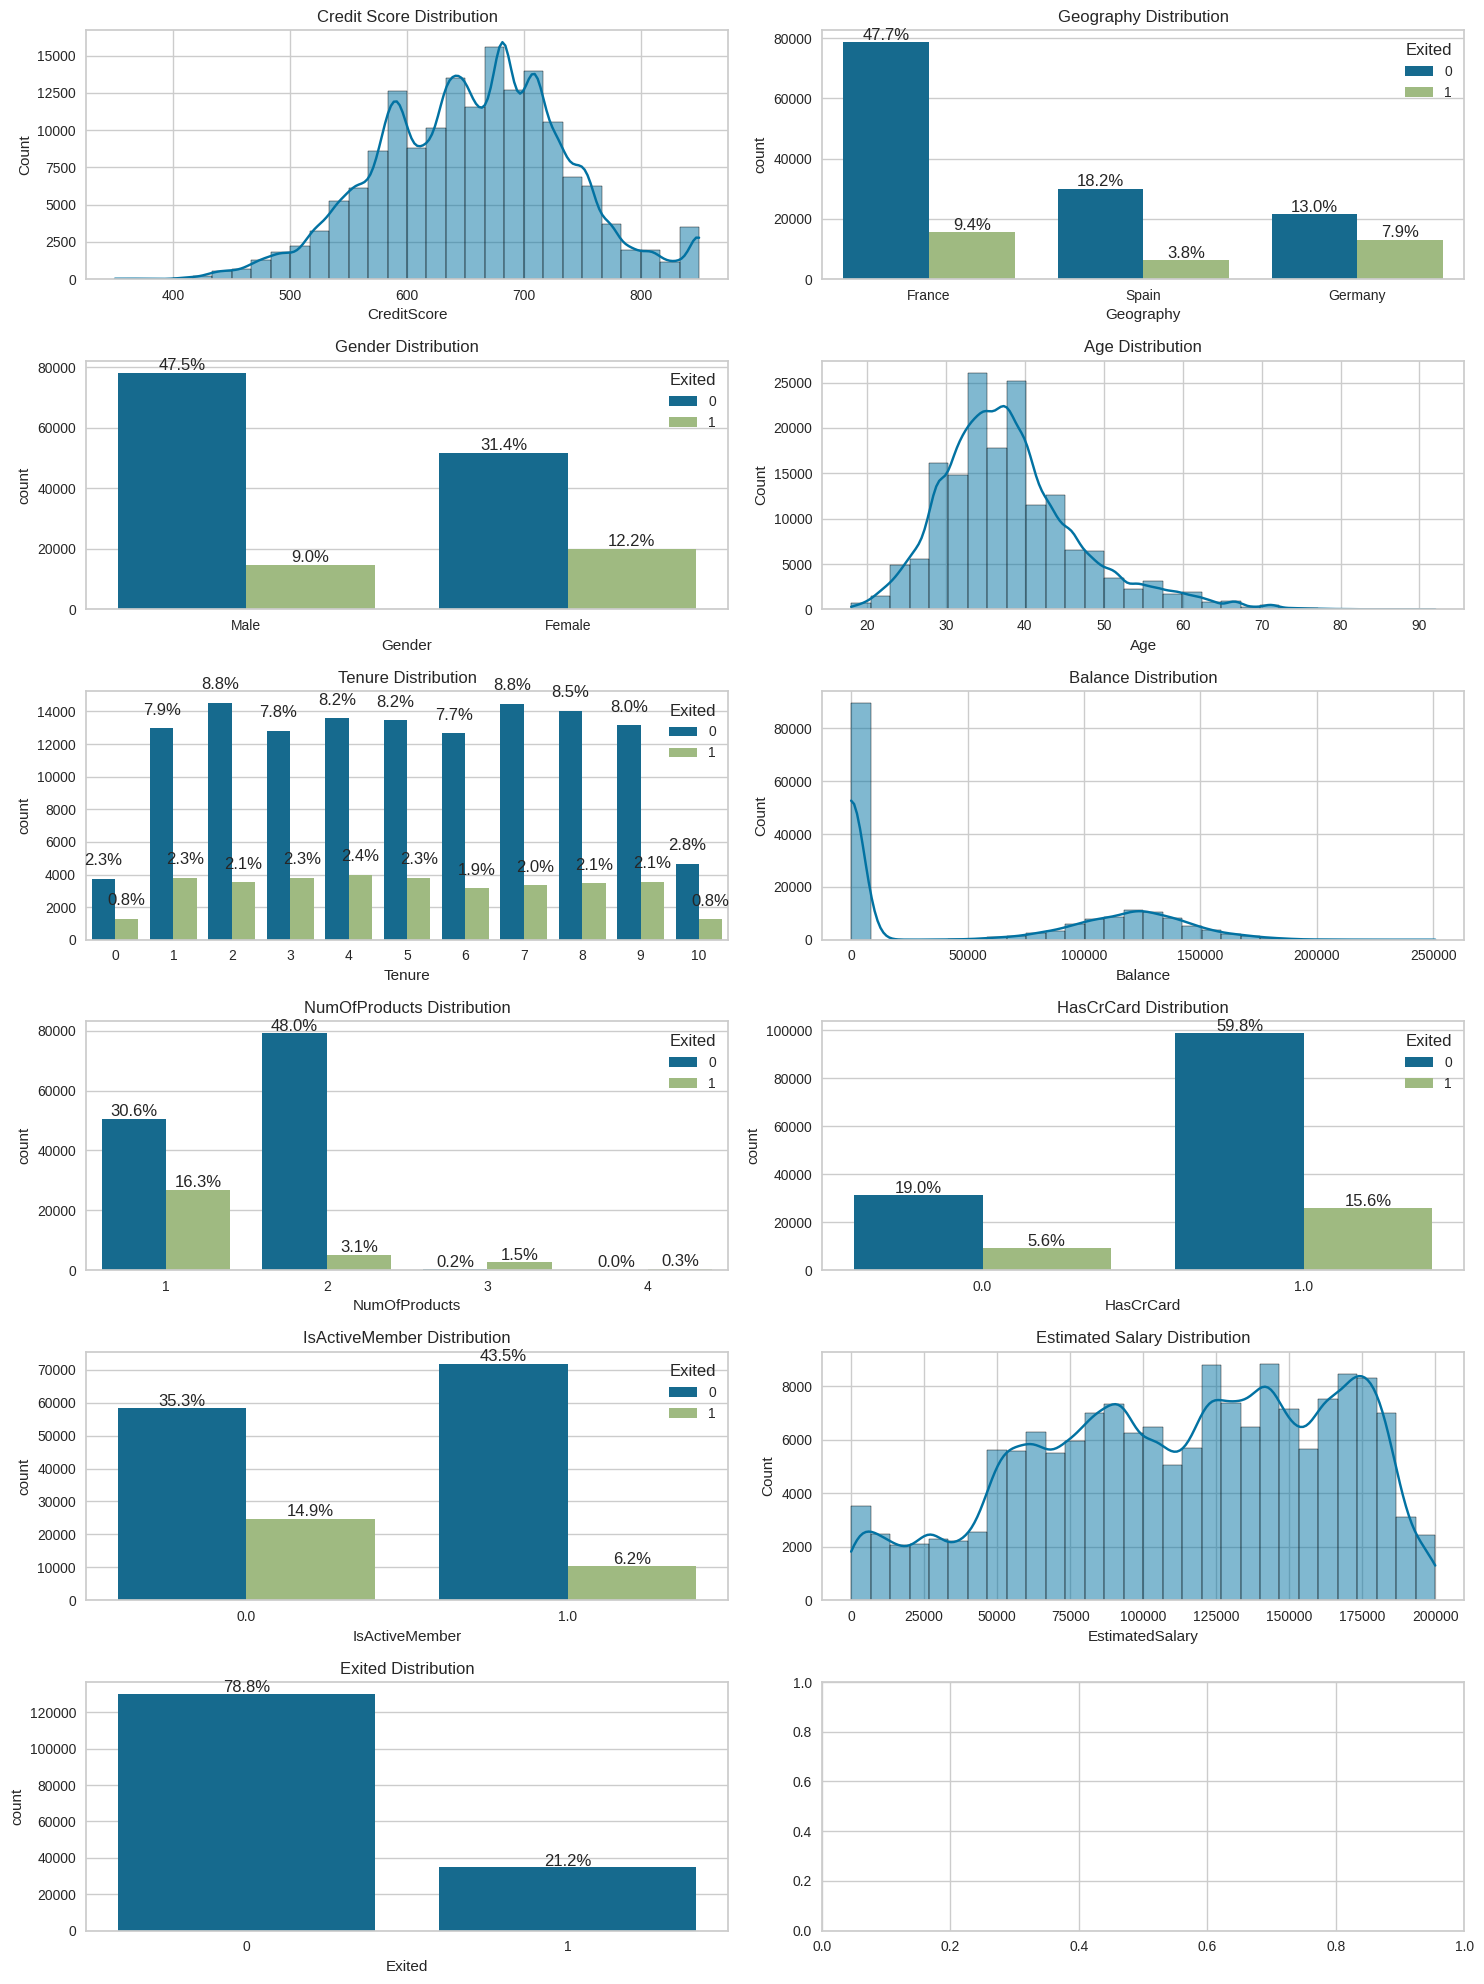

In [ ]:
# 시각화(전처리X, Id, CustomerId, Surname 제외)
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

sns.histplot(train['CreditScore'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Credit Score Distribution')

custom_countplot(sns.countplot(data=train, x='Geography', hue='Exited', ax=axes[0,1]),train.shape[0])
axes[0,1].set_title('Geography Distribution')

custom_countplot(sns.countplot(data=train, x='Gender', hue='Exited', ax=axes[1,0]),train.shape[0])
axes[1,0].set_title('Gender Distribution')

sns.histplot(train['Age'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Age Distribution')

custom_countplot(sns.countplot(data=train, x='Tenure', hue='Exited', ax=axes[2, 0]), train.shape[0])
axes[2, 0].set_title('Tenure Distribution')

sns.histplot(train['Balance'], bins=30, kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Balance Distribution')

custom_countplot(sns.countplot(data=train, x='NumOfProducts', hue='Exited', ax=axes[3, 0]), train.shape[0])
axes[3, 0].set_title('NumOfProducts Distribution')

custom_countplot(sns.countplot(data=train, x='HasCrCard', hue='Exited', ax=axes[3, 1]), train.shape[0])
axes[3, 1].set_title('HasCrCard Distribution')

custom_countplot(sns.countplot(data=train, x='IsActiveMember', hue='Exited', ax=axes[4, 0]), train.shape[0])
axes[4, 0].set_title('IsActiveMember Distribution')

sns.histplot(train['EstimatedSalary'], bins=30, kde=True, ax=axes[4, 1])
axes[4, 1].set_title('Estimated Salary Distribution')

custom_countplot(sns.countplot(data=train, x='Exited', ax=axes[5, 0]), train.shape[0])
axes[5, 0].set_title('Exited Distribution')

plt.tight_layout()
plt.show()


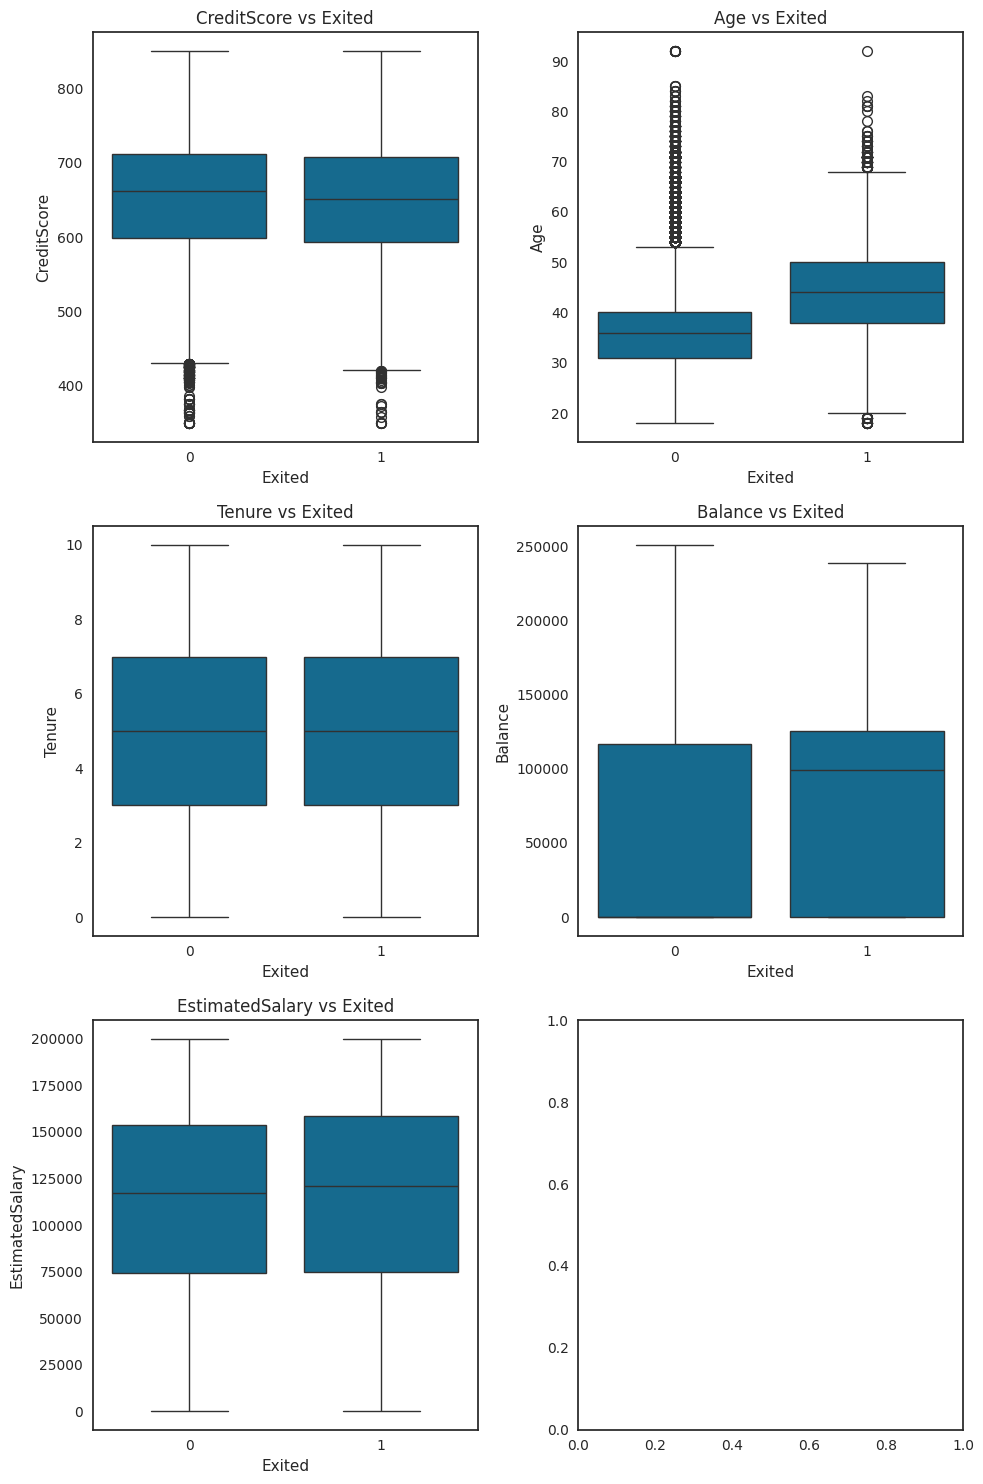

In [ ]:
# 박스 플롯(연속형 변수)
fig, axes = plt.subplots(3, 2, figsize=(10,15))
sns.set_style("whitegrid")

sns.boxplot(x='Exited', y='CreditScore', data=train, ax=axes[0,0])
axes[0,0].set_title('CreditScore vs Exited')

sns.boxplot(x='Exited', y='Age', data=train, ax=axes[0,1])
axes[0,1].set_title('Age vs Exited')

sns.boxplot(x='Exited', y='Tenure', data=train, ax=axes[1,0])
axes[1,0].set_title('Tenure vs Exited')

sns.boxplot(x='Exited', y='Balance', data=train, ax=axes[1,1])
axes[1,1].set_title('Balance vs Exited')

sns.boxplot(x='Exited', y='EstimatedSalary', data=train, ax=axes[2,0])
axes[2,0].set_title('EstimatedSalary vs Exited')

plt.tight_layout()
plt.show()

### 데이터 정제

In [ ]:
# 변수 제거(의미, 중복치)

## train(원본) 중복치 : 0
train.duplicated().sum()

## train(id 제거) 중복치 : 0
train_1 = train.drop(columns = 'id')
train_1.duplicated().sum()

## train(CustomerId 제거) 중복치 : 0
train_2 = train.drop(columns = 'CustomerId')
train_2.duplicated().sum()

## train(id, CustomerId 제거) 중복치 : 54개
train_3 = train.drop(columns = ['id','CustomerId'])
train_3.duplicated().sum()

## train(customerid만) 중복치 : 141813
train['CustomerId'].duplicated().sum()

## train(EstimatedSalary) : 109736
train['EstimatedSalary'].duplicated().sum()

## train(CustomerId, Balance, EstimatedSalary, Surname, Gender, Geography) : 12186
train.duplicated(subset = ['CustomerId','Balance','EstimatedSalary','Surname','Gender','Geography']).sum()

## id, CustomerId(CustomerId 고유값으로써 기능 상실) 변수 제거
train.drop(columns = ['id','Surname','CustomerId'], inplace=True)
test.drop(columns = ['id','Surname','CustomerId'], inplace=True)

# 중복치 제거(이름을 포함해 나머지 값들 모두 동일한 중복치는 분석에 무의미하다 판단)
train = train.drop_duplicates()

12186

In [ ]:
# type 변경 : float -> int
train[['HasCrCard','IsActiveMember']] = train[['HasCrCard','IsActiveMember']].astype(int)
test[['HasCrCard','IsActiveMember']] = test[['HasCrCard','IsActiveMember']].astype(int)

In [ ]:
# 파생변수 생성

# Age 변수
## Age_group : 20대 이하, 30대, 40대, 50대 이상

train[train['Age'] > 50].count()                                          # 50세 이상 : 15127
train[train['Age'] > 55].count()                                          # 55세 이상 : 8377
train[(train['Age'] > 50) & (train['Age'] < 55)].count()                  # 50세 초과 55세 미만 : 5650
train[(train['Age'] > 40) & (train['Age'] < 50)].count()                  # 40대 : 35523
train[(train['Age'] > 30) & (train['Age'] < 40)].count()                  # 30대 : 75918
train[(train['Age'] > 20) & (train['Age'] < 30)].count()                  # 20대 : 22866
train[(train['Age'] < 20)].count()                                        # 10대 : 332


# age_group 생성
train['age_group'] = pd.cut(train['Age'], bins=[0, 30, 40, 50, 100],
                         labels=['20', '30', '40','50'],right=False)
test['age_group'] = pd.cut(test['Age'], bins=[0, 30, 40, 50, 100],
                         labels=['20', '30', '40', '50'],right=False)

# Balance 변수
## Balance_group : 0과 1
train[train['Balance'] ==0].count() # 89648
train[train['Balance']!=0].count() # 75386

# Balance_group 생성
train['Balance_group'] = train['Balance'].map(lambda x:0 if x==0 else 1)
test['Balance_group'] = test['Balance'].map(lambda x:0 if x==0 else 1)

# 변수 조합
## Age + CreditScore
train['CreditScoreByAge'] = train['Age'].map(train.groupby('Age')['CreditScore'].mean())
test['CreditScoreByAge'] = test['Age'].map(train.groupby('Age')['CreditScore'].mean())

## Age + Balance
train['BalanceByAge'] = train['Age'].map(train.groupby('Age')['Balance_group'].mean())
test['BalanceByAge'] = test['Age'].map(train.groupby('Age')['Balance_group'].mean())

## Balance + EstimatedSalary
train['EstimatedSalaryByBalanceGroup'] = train['Balance'].map(train.groupby('Balance')['EstimatedSalary'].mean())
test['EstimatedSalaryByBalanceGroup'] = test['Balance'].map(train.groupby('Balance')['EstimatedSalary'].mean())

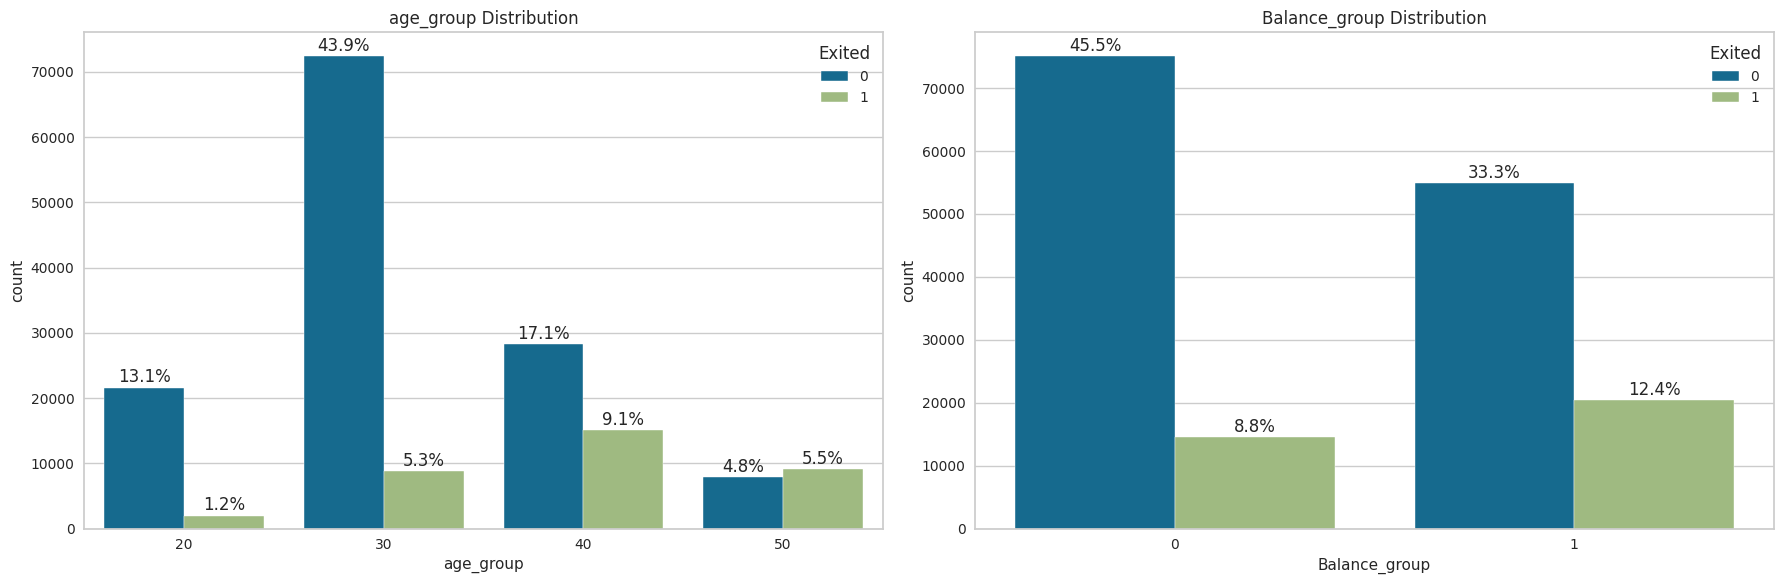

In [ ]:
# age_group, Balance_group 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

custom_countplot(sns.countplot(data=train, x='age_group', hue='Exited', ax=axes[0]),train.shape[0])
axes[0].set_title('age_group Distribution')

custom_countplot(sns.countplot(data=train, x='Balance_group', hue='Exited', ax=axes[1]),train.shape[0])
axes[1].set_title('Balance_group Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# 인코딩 : 고유값 개수가 적어 one hot 인코딩
train = pd.get_dummies(train, columns=['Geography', 'Gender'],dtype=int)
test = pd.get_dummies(test, columns=['Geography', 'Gender'],dtype=int)

In [ ]:
# 스케일링 : 이상치 기준으로 스케일링 적용
# Standard
scaler_Standard = StandardScaler()
train[['Balance']] = scaler_Standard.fit_transform(train[['Balance']])
test[['Balance']] = scaler_Standard.fit_transform(test[['Balance']])

# Robust
scaler_Robust = RobustScaler()
train[['CreditScore','Age']] = scaler_Robust.fit_transform(train[['CreditScore','Age']])
test[['CreditScore','Age']] = scaler_Robust.fit_transform(test[['CreditScore','Age']])

# MinMax
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
scaler_MinMax = MinMaxScaler()
train[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(train[['Tenure','EstimatedSalary']])
test[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(test[['Tenure','EstimatedSalary']])

### 상관관계 히트맵

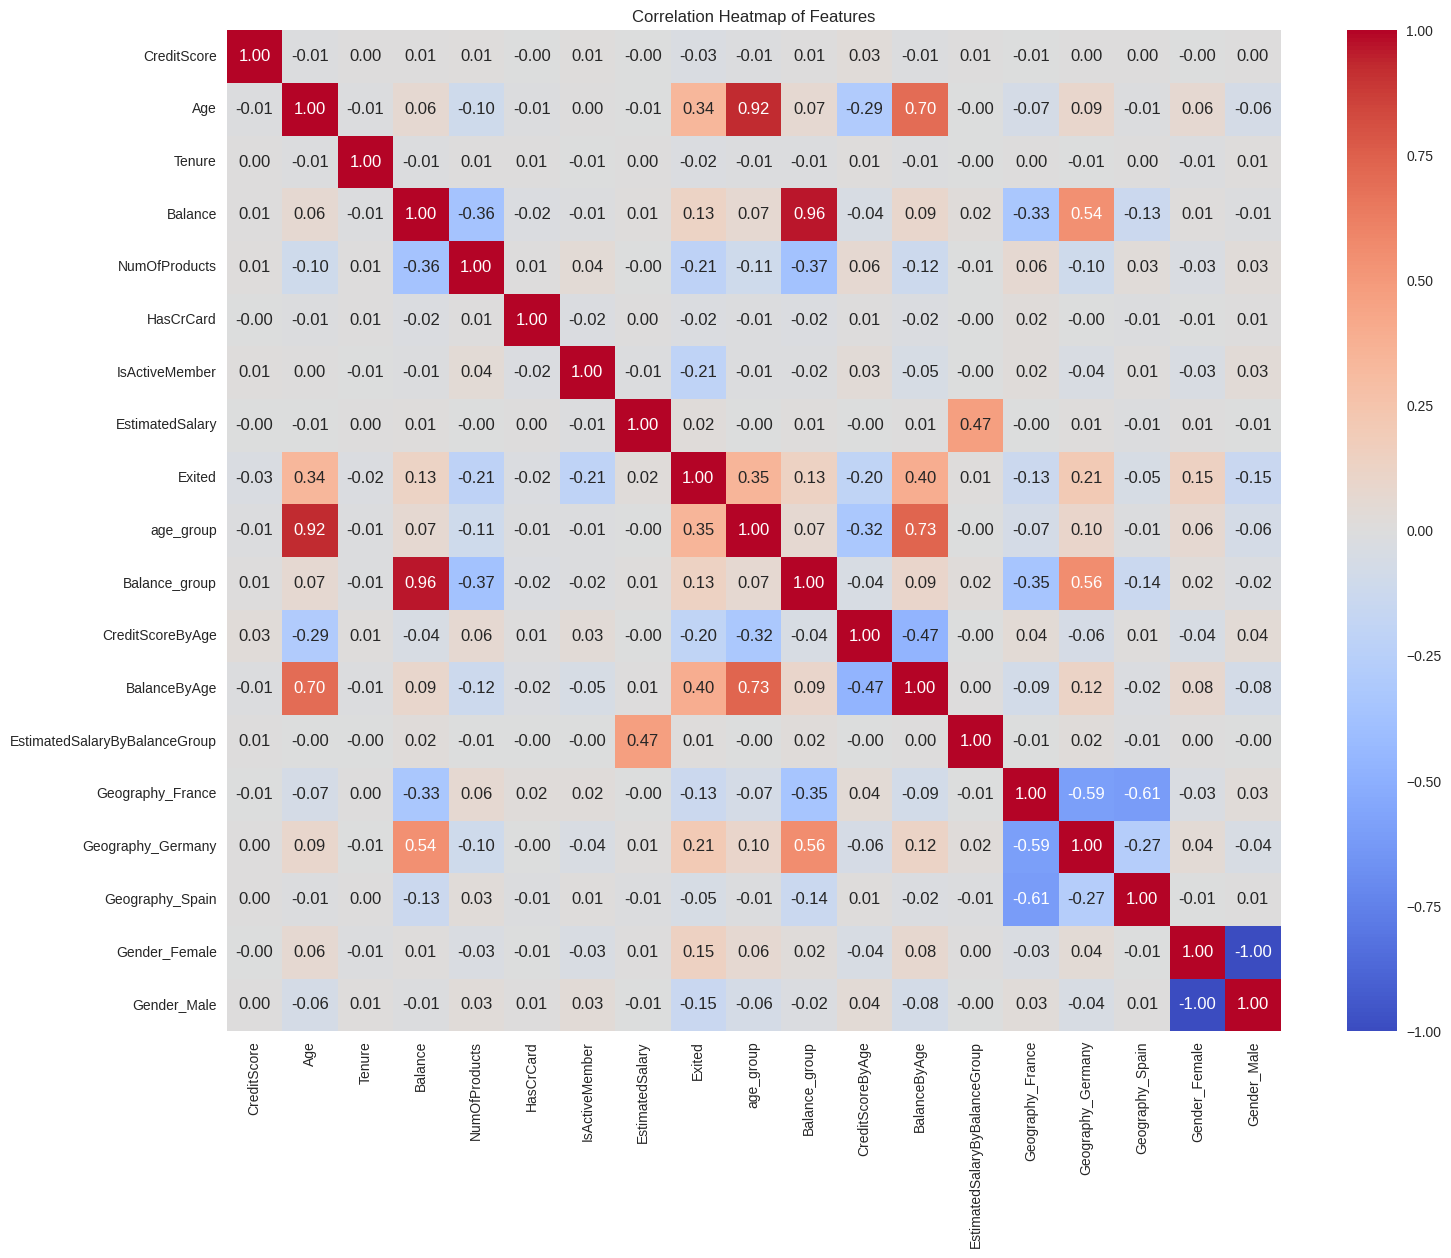

In [ ]:
# 피처 간 상관 관계 계산
correlation_matrix = train.corr()

# 상관 관계 히트맵 시각화
plt.figure(figsize=(17, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()